# Group 19 - MS5

## Semantic Segmentation of Brain MRI Scans using Transfer Learning

Karan Daryanani, Zahra Rasouli, Marium Tapal

## Table Of Contents:
* [Libraries](#libraries)
* [Problem Statement](#problem-statement)
* [EDA and Visualization](#eda)
* [Data Preperation](#data-prep)
* [Early Models](#early-model)
* [Final Model](#final-model)
* [Results and Inference](#results)
* [Conclusion and Future Work](#conclusion)

### Libraries <a class="anchor" id="libraries"></a>

In [13]:
# Load Packages
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline
import sys
sys.path.append('/home/u_21617679/.local/lib/python3.10/site-packages')
! pip install nibabel
import nibabel as nib
import tensorflow as tf
import time
import random
from tqdm import tqdm
import pathlib
import resource
from PIL import Image

# Tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Concatenate, Lambda
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Activation, BatchNormalization

# sklearn
from sklearn.model_selection import train_test_split

# skimage
from skimage.transform import resize

Defaulting to user installation because normal site-packages is not writeable


## Problem Statement <a class="anchor" id="problem-statement"></a> 

The problem at hand is to build a model that performs image segmentation on the medical images from the Brain Tumor dataset. Our goal is to build a model that achieves a good performance in 3 metrics: loss, accuracy, and IoU (intersection over union) score. The IoU is a metric commonly used in object detection and image segmentation. It is especially helpful for us because we are interested in capturing the tumorous parts of the brain.

To achieve this end, we use transfer learning on a U-Net algorithm with pre-trained weights from ImageNet. We expand this architecture until we find an acceptable performance in all three metrics.

## Explore and Visualize Data <a class="anchor" id="eda"></a>

The data for our project consists of medical images in the NIfTI file format. This medical imaging data is annotated and is divided into 10 different segmentation tasks, each of which has a different number of labels. In this project, we are choosing one task, the brain tumor dataset. The brain tumor images each have a shape of (240, 240,155,4) (code in appendix file).

The Brain Tumor dataset is 4 dimensional, or better understood as a list of 3-D data ‘cubes’. In a standard setting, this 4th dimension is time, but here the dimensions are related to the modality of the MRI. Specifically - FLAIR (label = 0) removes the signal from the cerebrospinal fluid in the resulting images. T1 Weighted images (label = 1) enhances the signal of fatty tissue, making grey matter brighter than white matter, and cerebrospinal fluid appearing as dark instead of bright. Generally, the T1gd (label = 2) reveals the tumor mass itself, and the T2w (label = 3) reveals associated swelling and the spread of the tumor. 

The pixel data types are float64. The shapes of all the images are the same. 

#### Images 

The following plot shows the range of the pixel values for all the images.

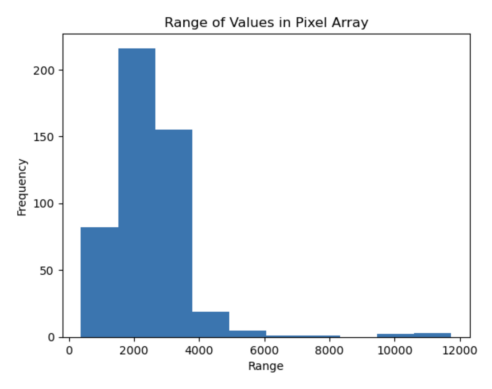

In [2]:
plt.imshow(plt.imread("/home/u_21617679/Task01_BrainTumour_project/pictures/1.png"))
plt.axis('off')
plt.show()

The following plot shows the distributions for the first 100 images and how they differ. It looks like the general distribution is the same, even though there are a few outliers.

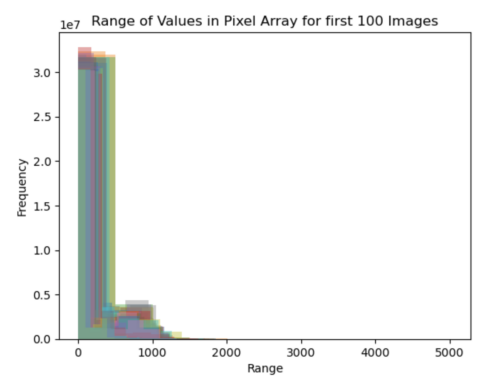

In [3]:
plt.imshow(plt.imread("/home/u_21617679/Task01_BrainTumour_project/pictures/2.png"))
plt.axis('off')
plt.show()

Now we look at the distribution of labels in the first 100 images. The Y-axis is in log-scale.

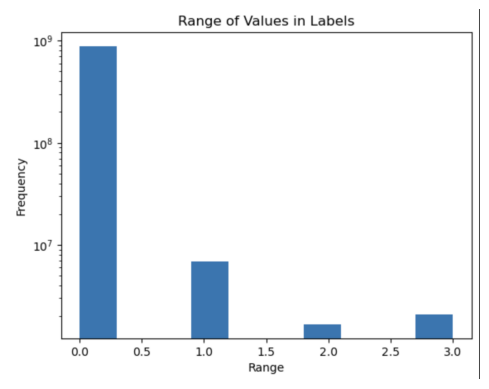

In [4]:
plt.imshow(plt.imread("/home/u_21617679/Task01_BrainTumour_project/pictures/3.png"))
plt.axis('off')
plt.show()

#### Labels

We have 4 unique labels which we one-hot encode in the models. The labels, are [0, 1, 2, 3] which mean:

* 0 : background
* 1 : edema
* 2 : non-enhancing tumor 
* 3 : enhancing tumor 

We can see that the majority of the pixels are background, with a small number of edema, non-enhancing tumor, and enhancing tumor pixels. We see that there is a class imbalance, and our models take that into account.

    
The following plot shows some example images which highlight the segmentation task. The white parts of the images are what we are especially interested in identifying.

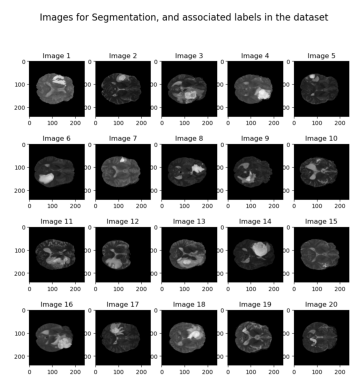

In [5]:
plt.imshow(plt.imread("/home/u_21617679/Task01_BrainTumour_project/pictures/4.png"))
plt.axis('off')
plt.show()

#### Modalities 

As mentioned above, each original MRI image of the brain comes in 4 modalities, which give us different insights into the locations of the tumor.

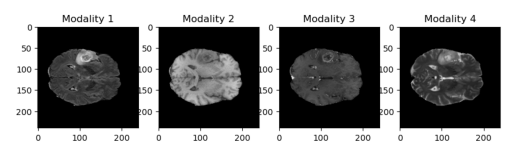

In [6]:
plt.imshow(plt.imread("/home/u_21617679/Task01_BrainTumour_project/pictures/5.png"))
plt.axis('off')
plt.show()

#### Data Challenges

The brain tumor dataset comes with heterogeneously located ‘targets’, a fair amount of label imbalance, as well as a large amount of background (label 0) as compared to a small target area of cancerous cells (labels 1-3).

## Data Preparation <a class="anchor" id="data-prep"></a>

As explained in the last section, the MRI data is structured as a 4-dimensional dataset, which can be thought of as a collection of four 3-dimensional spatial images, in the x, y, and z feature space. 

We initially thought of trying to work with 3-d segmentation algorithms, but a general understanding in this space is that there is less generalisability of these models when faced with new images. We then considered the potential of incorporating the different spatial images as individual 2-dimensional slices into the model, such the model can better learn the 'edges' of the tumors.

such that it learns from all the different modalities when updating its weights.

In the code below, we therefore process the data in the following steps:
- Load images individually
- Break up each image into four spatial images, one for each modality
- Split each spatial image into 2-dimensional slices along the z-axis
- Create 2-dimensional images that have 3 colour channels by concatenating 3 identical slices from each image for input into the pre-trained U-Net model (U-Net typically takes images with 3 RGB channels as an input)
- Rescaled pixel values
- One-hot encoded the 4 labels
- Created a tensorflow dataset pipeline with a batch size of 64
- Created train, test, and validation sets for model training and evaluation

In [2]:
# get project file paths
project = '/home/u_21617679'
brain_data = os.path.join(project, 'Task01_BrainTumour_project/imagesTr/')
labels = os.path.join(project, 'Task01_BrainTumour_project/labelsTr/')

In [3]:
# get file paths of images and labels
data = glob.glob(brain_data + '*.nii.gz')
data_labels = glob.glob(labels + '*.nii.gz')

In [48]:
%%script echo skipping
# helper functions to load and process data

# load files
def loadfile(file):
    img = nib.load(file)
    img = img.get_fdata()
    return img

# split image into 2D slices along the z-axis
def split_image(image):
    slices = []
    for i in range(image.shape[2]):
        slices.append(image[:,:,i])
    return slices

# split labels into 2D slices along the z-axis
def split_label(label):
    slices = []
    for i in range(label.shape[2]):
        slices.append(label[:,:,i])
    return slices

# save slices as png files
def save_slices(slices, filename):
    for i, slice in enumerate(slices):
        plt.imsave(filename + str(i) + '.png', arr=slice, cmap="gray")

In [60]:
%%script echo skipping

# load all images in a loop
foldername = os.path.join(project, 'Task01_BrainTumour_project/sliced_images_train/')

for i in range(len(data)):
    image = loadfile(data[i])
    label_img = loadfile(data_labels[i])
    image_num = data[i][-16:-7]
    # for each modality
    for mod in range(0,4):
    
        image_mod = image[:,:,:, mod]
        
        # split image into slices
        slices = split_image(image_mod)
        file_name = foldername+image_num+'_'+str(mod)+'_'
        save_slices(slices, file_name)
        
        # split label image into slices
        label_slices = split_image(label_img)
        label_file_name = foldername+image_num+'_'+str(mod)+'_label_'
        save_slices(label_slices, label_file_name)
        
        # remove from memory
        del slices
        del label_slices
        del image_mod

CPU times: user 1h 4min 27s, sys: 3min 34s, total: 1h 8min 1s
Wall time: 3h 58min 24s


In [76]:
%%script echo skipping

# move label data to a new directory

# create two folders for labels and images
foldername = os.path.join(project, 'Task01_BrainTumour_project/sliced_images_train/')
foldername_labels = os.path.join(project, 'Task01_BrainTumour_project/sliced_labels_train/')

# get files with 'label' in them
files = glob.glob(foldername+'/*label*')
files = [f.split('/')[-1] for f in tqdm(files)]

100%|██████████| 299880/299880 [00:00<00:00, 1849617.34it/s]


In [79]:
%%script echo skipping
# move label files from sliced_images_train to sliced_labels_train
# get file names in sliced_images_train that have label files
for file in tqdm(files):
    os.replace(foldername + "/" + file, foldername_labels + "/" + file)

100%|██████████| 299880/299880 [29:38<00:00, 168.62it/s]

CPU times: user 20.9 s, sys: 20 s, total: 40.9 s
Wall time: 29min 38s


In [4]:
%%time
# create tensorflow dataset and image preprocessing

# Define directories containing train and label images
train_dir = pathlib.Path("sliced_images_train")
label_dir = pathlib.Path("sliced_labels_train")

img_size = (224, 224)

# Define function to load images and labels
def load_image_and_label(file_path, label_path):
    image = tf.io.decode_png(tf.io.read_file(file_path), channels=1)
    image = tf.image.resize(image, img_size)
    label = tf.io.decode_png(tf.io.read_file(label_path), channels=1)
    label = tf.image.resize(label, img_size)
    # Cast the label to an integer type
    label = tf.cast(label, tf.int32)
    # Convert the label to a one-hot encoding
    label = tf.squeeze(label, axis=-1)
    label = tf.one_hot(label, depth=4)
    # rescaling image
    image = tf.cast(image, tf.float32)
    image = image / 255

    return image, label

# Create dataset from train and label images
image_paths = sorted([str(path) for path in train_dir.glob("*.png")])
label_paths = sorted([str(path) for path in label_dir.glob("*.png")])
dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

# Load train data and labels as a TensorFlow dataset
dataset = dataset.map(load_image_and_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)

2023-05-07 01:38:59.069944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-07 01:38:59.310764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-07 01:38:59.311104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Cause: Unable to locate the source code of <function load_image_and_label at 0x7f55f15ea2a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function load_image_and_label at 0x7f55f15ea2a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate th

In [5]:
# Split the dataset into training and testing sets

# bath and shuffle batches
batch_size = 64
dataset = dataset.batch(batch_size)

# Split the dataset into training and testing sets
train_ratio = 0.8  
num_samples = 484 * 4 * 155
num_train = int(num_samples * train_ratio)
num_test = num_samples - num_train

# Get the number of batches required for each set
num_train_batches = int(num_train / batch_size)

# Split the TensorFlow dataset into two sets based on the number of batches
train_set_ = dataset.take(num_train_batches)
test_set = dataset.skip(num_train_batches)

In [6]:
# Split the dataset into training and validation sets
num_samples = len(train_set_) * batch_size
num_train = int(num_samples * train_ratio)
num_val = num_samples - num_train

# Get the number of batches required for each set
num_train_batches = int(num_train / batch_size)

# Split the TensorFlow dataset into two sets based on the number of batches
train_set = train_set_.take(num_train_batches)
val_set = train_set_.skip(num_train_batches)

In [7]:
# remove from memory
del dataset
del num_samples
del num_train
del num_test
del num_val
del num_train_batches

## Early Model Attempts <a class="anchor" id="early-model"></a>

Our early model attempts were building on U-Net architecture described in the Advanced Section on image segementation. 

In [75]:
# build model
def build_model(num_classes, weights='imagenet'):
    
    # Model input
    input_shape = [224, 224, 1] # height, width, channels
    
    # https://stackoverflow.com/questions/52065412/how-to-use-1-channel-images-as-inputs-to-a-vgg-model
    img_size_target = 224
    img_input = Input(shape=(img_size_target, img_size_target, 1))
    img_conc = Concatenate()([img_input, img_input, img_input])  

    # Load a pretrained model from keras.applications
    tranfer_model_base = keras.applications.MobileNetV2(input_tensor=img_conc, weights='imagenet', include_top=False)

    # Freeze the mobileNet model layers
    tranfer_model_base.trainable = False

    conv0 = tranfer_model_base.get_layer("expanded_conv_project").output # 112 x 112
    conv1 = tranfer_model_base.get_layer("block_2_project").output # 56 x 56
    conv2 = tranfer_model_base.get_layer("block_5_project").output # 28 x 28
    conv3 = tranfer_model_base.get_layer("block_12_project").output # 14 x 14

    up6 = tranfer_model_base.output  # 7 x 7 
    conv7 = up6

    up8 = keras.layers.concatenate([keras.layers.UpSampling2D()(conv7), conv3], axis=-1)
    conv8 = keras.layers.Conv2D(filters=128,kernel_size=(3, 3),padding='same',activation='relu',name='conv8_1_3x3')(up8)

    up9 = keras.layers.concatenate([keras.layers.UpSampling2D()(conv8), conv2], axis=-1)
    conv9 = keras.layers.Conv2D(filters=64,kernel_size=(3, 3),padding='same',activation='relu',name='conv9_1_3x3')(up9)

    up10 = keras.layers.concatenate([keras.layers.UpSampling2D()(conv9), conv1], axis=-1)
    conv10 = keras.layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv10_1_3x3')(up10)

    up11 = keras.layers.concatenate([keras.layers.UpSampling2D()(conv10), conv0], axis=-1)
    conv11 = keras.layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv11_1_3x3')(up11)

    up12 = keras.layers.UpSampling2D()(conv11)
    conv12 = keras.layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv12_1_3x3')(up12)

    # Output Layer
    output = keras.layers.Conv2D(4,kernel_size=(1, 1), activation="softmax", name="prediction")(conv12)
    
    # Build model
    model = Model(inputs=tranfer_model_base.input, outputs=[output], name='unet_mobilenet_'+str(int(time.time())))

    return model

# Define the number of classes, and whether to use pre-trained weights
num_classes = 4

# Build the model
model_base = build_model(num_classes)

# Print model summary
model_base.summary()

Model: "unet_mobilenet_1683478815"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_128 (Concatenate)  (None, 224, 224, 3)  0           ['input_32[0][0]',               
                                                                  'input_32[0][0]',               
                                                                  'input_32[0][0]']               
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['concate

### Early Model with Different Learning Rates

We ran the model for 3 different learning rates: 1e-3 (defualt), 1e-2 (larger), and 1e-4 (smaller). The results are summarized in the table below. As highlighted entries show, both the training and validation losses are unacceptably high. Since the validation accuracy of our model is on par with the training accuracy (both very high), the model could not be overfitting. However, we suspect that there might be a problem with the gradients. 

We chose the best learning rate and ran the model again with 5 epochs, to be able to fully observe how the metrics change with given sufficient training time. The results are still unacceptable.

In the final attempt, we add skip connections, batch normalization, maxpooling, and dropout layers to overcome this issue.

| Metric/Learning Rate | 1e-2 | 1e-3 | 1e-4 |
| --- | --- | --- |--- |
| Accuracy | 0.9764 | 0.9777 | 0.9709 |
| Loss | **6.99e13**| **4.52e10** | **3.18e6** |
| Mean IoU | 0.9411 | 0.9541 | 0.9330 |
| Validation Accuracy | 0.9999 | 0.9999 | 0.9999 |
| Validation Loss | **1.17e14** | **7.48e10** | **7.54e6** |
| Validation Mean IoU |  0.9934 | 0.9934 | 0.9934 |  

#### 1e-3

In [69]:
%%script echo skipping

# learning rate 
model_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['Accuracy', tf.keras.metrics.MeanIoU(num_classes=4)])

history_base_4 = model_base.fit(train_set, epochs=1, validation_data=val_set)

3000/3000 [==============================] - 1149s 382ms/step - loss: 45171126272.0000 - Accuracy: 0.9777 - mean_io_u_10: 0.9541 - val_loss: 74813030400.0000 - val_Accuracy: 0.9999 - val_mean_io_u_10: 0.9934


#### 1e-4

In [66]:
%%script echo skipping

model_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['Accuracy', tf.keras.metrics.MeanIoU(num_classes=4)])
history_base = model_base.fit(train_set, epochs=1, validation_data=val_set)

#### 1e-2

In [71]:
%%script echo skipping

model_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
              loss='categorical_crossentropy',
              metrics=['Accuracy', tf.keras.metrics.MeanIoU(num_classes=4)])

history_base_2 = model_base.fit(train_set, epochs=1, validation_data=val_set)

3000/3000 [==============================] - 1164s 386ms/step - loss: 69906800312320.0000 - Accuracy: 0.9764 - mean_io_u_11: 0.9411 - val_loss: 116667963146240.0000 - val_Accuracy: 0.9999 - val_mean_io_u_11: 0.9934


### Learning rate 1e-4 with 5 epochs

Metrics: 

In [76]:
%%script echo skipping

# compile model
model_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['Accuracy', tf.keras.metrics.MeanIoU(num_classes=4)])

history_base_5_epochs = model_base.fit(train_set, epochs=5, validation_data=val_set)

Epoch 1/5
3000/3000 [==============================] - 1167s 387ms/step - loss: 88196440064.0000 - Accuracy: 0.9776 - mean_io_u_13: 0.9601 - val_loss: 74577633280.0000 - val_Accuracy: 0.9999 - val_mean_io_u_13: 0.9934
Epoch 2/5
3000/3000 [==============================] - 1158s 386ms/step - loss: 2939971698688.0000 - Accuracy: 0.9805 - mean_io_u_13: 0.9662 - val_loss: 318305998995456.0000 - val_Accuracy: 0.0045 - val_mean_io_u_13: 0.2532
Epoch 3/5
3000/3000 [==============================] - 1156s 385ms/step - loss: 22028740460544.0000 - Accuracy: 0.9804 - mean_io_u_13: 0.9661 - val_loss: 9646818459648.0000 - val_Accuracy: 0.9999 - val_mean_io_u_13: 0.9934
Epoch 4/5
3000/3000 [==============================] - 1161s 387ms/step - loss: 72048839753728.0000 - Accuracy: 0.9807 - mean_io_u_13: 0.9664 - val_loss: 50169810780160.0000 - val_Accuracy: 0.9999 - val_mean_io_u_13: 0.9934
Epoch 5/5
3000/3000 [==============================] - 1160s 387ms/step - loss: 195005977198592.0000 - Accuracy

In [83]:
%%script echo skipping

model_path_final = os.path.join(project, 'Task01_BrainTumour_project/model_weights/')
model_base.save(os.path.join(model_path_final, "model_base"))

skipping


In [ ]:
# load model
model_path_final = os.path.join(project, 'Task01_BrainTumour_project/model_weights/')
model_final_2 = tf.keras.models.load_model(os.path.join(model_path_final, "model_final_backup"))
model_final_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['Accuracy', tf.keras.metrics.MeanIoU(num_classes=4)])

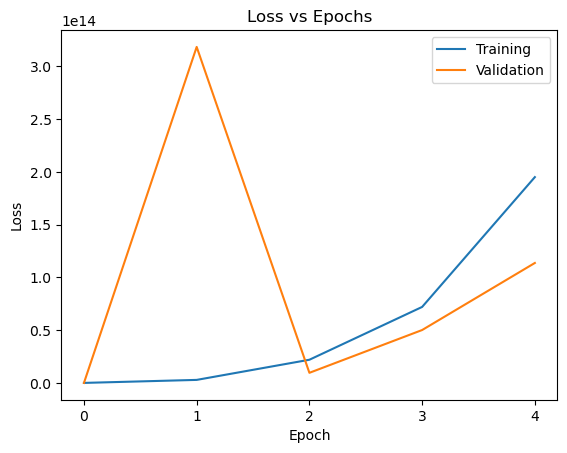

In [80]:
# plot history
fig, ax = plt.subplots(1, 3)

ax[0].plot(history_base_5_epochs.history['loss'], label='Training')
ax[0].plot(history_base_5_epochs.history['val_loss'], label = 'Validation')
ax[0].xlabel('epoch')
ax[0].xticks(range(0,5))
ax[0].ylabel('loss')
ax[0].title('loss vs epoch for early model with \nlearning rate 1e-4')
ax[0].legend()

ax[1].plot(history_base_5_epochs.history['accuracy'], label='Training')
ax[1].plot(history_base_5_epochs.history['val_accuracy'], label = 'Validation')
ax[1].xlabel('epoch')
ax[1].xticks(range(0,5))
ax[1].ylabel('accuracy')
ax[1].title('accuracy vs epoch for early model with \nlearning rate 1e-4')
ax[1].legend()

ax[2].plot(history_base_5_epochs.history['mean_io_u'], label='Training')
ax[2].plot(history_base_5_epochs.history['val_mean_io_u'], label = 'Validation')
ax[2].xlabel('epoch')
ax[2].xticks(range(0,5))
ax[2].ylabel('mean IoU')
ax[2].title('mean IoU vs epoch for early model with \nlearning rate 1e-4')
ax[2].legend()

plt.tight_layout()
plt.show()

fig.savefig("/home/u_21617679/Task01_BrainTumour_project/pictures/subplots_early_model_5_epochs.png')

## Final Model <a class="anchor" id="final-model"></a>

Given our results from our early attempts, we decided to add skip connections, batch normalization, maxpooling, and dropout layers to our model. 

In [90]:
# build model
def build_model(num_classes, weights='imagenet'):
    
    # Model input
    input_shape = [224, 224, 1] # height, width, channels
    
    # https://stackoverflow.com/questions/52065412/how-to-use-1-channel-images-as-inputs-to-a-vgg-model
    img_size_target = 224
    img_input = Input(shape=(img_size_target, img_size_target, 1))
    img_conc = Concatenate()([img_input, img_input, img_input])  

    # Load a pretrained model from keras.applications
    tranfer_model_base = keras.applications.MobileNetV2(input_tensor=img_conc, weights='imagenet', include_top=False)

    # Freeze the mobileNet model layers
    tranfer_model_base.trainable = False

    conv0 = tranfer_model_base.get_layer("expanded_conv_project").output # 112 x 112
    conv1 = tranfer_model_base.get_layer("block_2_project").output # 56 x 56
    conv2 = tranfer_model_base.get_layer("block_5_project").output # 28 x 28
    conv3 = tranfer_model_base.get_layer("block_12_project").output # 14 x 14

    up6 = tranfer_model_base.output  # 7 x 7 
    conv7 = up6
    
    up8 = keras.layers.concatenate([keras.layers.UpSampling2D()(conv7), conv3], axis=-1)
    conv8 = keras.layers.Conv2D(filters=128,kernel_size=(3, 3),padding='same',activation='relu',name='conv8_1_3x3')(up8)
    norm1 = BatchNormalization()(conv8)
    
    up9 = keras.layers.concatenate([keras.layers.UpSampling2D()(norm1), conv2], axis=-1)
    conv9 = keras.layers.Conv2D(filters=64,kernel_size=(3, 3),padding='same',activation='relu',name='conv9_1_3x3')(up9)
    norm2 = BatchNormalization()(conv9)
    
    up10 = keras.layers.concatenate([keras.layers.UpSampling2D()(norm2), conv1], axis=-1)
    conv10 = keras.layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv10_1_3x3')(up10)
    norm3 = BatchNormalization()(conv10)
    
    up11 = keras.layers.concatenate([keras.layers.UpSampling2D()(norm3), conv0], axis=-1)
    conv11 = keras.layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv11_1_3x3')(up11)
    merge1 = Concatenate(axis = 3)([conv11,up11])
    norm4 = BatchNormalization()(merge1)
    
    up12 = keras.layers.UpSampling2D()(norm4)
    conv12 = keras.layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv12_1_3x3')(up12)
    drop4 = keras.layers.Dropout(0.5)(conv12)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)                                        
    
    # Output Layer
    up13 = keras.layers.UpSampling2D()(pool4)
    output = keras.layers.Conv2D(4,kernel_size=(1, 1), activation="softmax", name="prediction")(up13)
    
    # Build model
    model = Model(inputs=tranfer_model_base.input, outputs=[output], name='unet_mobilenet_'+str(int(time.time())))

    return model

# Define the number of classes, and whether to use pre-trained weights
num_classes = 4

# Build the model
final_model = build_model(num_classes)

# Print model summary
final_model.summary()

Model: "unet_mobilenet_1683486970"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_145 (Concatenate)  (None, 224, 224, 3)  0           ['input_35[0][0]',               
                                                                  'input_35[0][0]',               
                                                                  'input_35[0][0]']               
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['concate

### Compile and Fit Model

In [91]:
# callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_io_u', patience=3, verbose=1, mode='min', restore_best_weights=True)
# compile model
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['Accuracy', tf.keras.metrics.MeanIoU(num_classes=4)])

In [92]:
history_final = final_model.fit(train_set, epochs=5, validation_data=val_set, callbacks=[early_stopping])

model_path_final = os.path.join(project, 'Task01_BrainTumour_project/model_weights/')
final_model.save(os.path.join(model_path_final, "model_final"))

Epoch 1/5


2023-05-07 19:18:31.130171: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inunet_mobilenet_1683486970/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3000/3000 [==============================] - ETA: 0s - loss: 0.3793 - Accuracy: 0.9862 - mean_io_u_15: 0.4434WARNING:tensorflow:Early stopping conditioned on metric `mean_io_u` which is not available. Available metrics are: loss,Accuracy,mean_io_u_15,val_loss,val_Accuracy,val_mean_io_u_15


3000/3000 [==============================] - 1952s 649ms/step - loss: 0.3793 - Accuracy: 0.9862 - mean_io_u_15: 0.4434 - val_loss: 0.0683 - val_Accuracy: 0.9999 - val_mean_io_u_15: 0.4415
Epoch 2/5
3000/3000 [==============================] - ETA: 0s - loss: 0.8473 - Accuracy: 0.9950 - mean_io_u_15: 0.9499WARNING:tensorflow:Early stopping conditioned on metric `mean_io_u` which is not available. Available metrics are: loss,Accuracy,mean_io_u_15,val_loss,val_Accuracy,val_mean_io_u_15


3000/3000 [==============================] - 1947s 649ms/step - loss: 0.8473 - Accuracy: 0.9950 - mean_io_u_15: 0.9499 - val_loss: 0.3130 - val_Accuracy: 0.9999 - val_mean_io_u_15: 0.9934
Epoch 3/5
3000/3000 [==============================] - ETA: 0s - loss: 1.0550 - Accuracy: 0.9975 - mean_io_u_15: 0.9882WARNING:tensorflow:Early stopping conditioned on metric `mean_io_u` which is not available. Available metrics are: loss,Accuracy,mean_io_u_15,val_loss,val_Accuracy,val_mean_io_u_15


3000/3000 [==============================] - 1946s 649ms/step - loss: 1.0550 - Accuracy: 0.9975 - mean_io_u_15: 0.9882 - val_loss: 0.6004 - val_Accuracy: 0.9999 - val_mean_io_u_15: 0.9934
Epoch 4/5
3000/3000 [==============================] - ETA: 0s - loss: 1.5285 - Accuracy: 0.9983 - mean_io_u_15: 0.9892WARNING:tensorflow:Early stopping conditioned on metric `mean_io_u` which is not available. Available metrics are: loss,Accuracy,mean_io_u_15,val_loss,val_Accuracy,val_mean_io_u_15


3000/3000 [==============================] - 1950s 650ms/step - loss: 1.5285 - Accuracy: 0.9983 - mean_io_u_15: 0.9892 - val_loss: 0.9263 - val_Accuracy: 0.9999 - val_mean_io_u_15: 0.9934
Epoch 5/5
3000/3000 [==============================] - ETA: 0s - loss: 1.9277 - Accuracy: 0.9989 - mean_io_u_15: 0.9899WARNING:tensorflow:Early stopping conditioned on metric `mean_io_u` which is not available. Available metrics are: loss,Accuracy,mean_io_u_15,val_loss,val_Accuracy,val_mean_io_u_15


3000/3000 [==============================] - 1949s 650ms/step - loss: 1.9277 - Accuracy: 0.9989 - mean_io_u_15: 0.9899 - val_loss: 1.2304 - val_Accuracy: 0.9999 - val_mean_io_u_15: 0.9934


2023-05-07 22:00:54.162634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-05-07 22:00:54.204442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-05-07 22:00:54.245546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-05-07

INFO:tensorflow:Assets written to: /home/u_21617679/Task01_BrainTumour_project/model_weights/model_final/assets


INFO:tensorflow:Assets written to: /home/u_21617679/Task01_BrainTumour_project/model_weights/model_final/assets


In [74]:
# load model
model_path_final = os.path.join(project, 'Task01_BrainTumour_project/model_weights/')
model_final = tf.keras.models.load_model(os.path.join(model_path_final, "model_final_backup"))
# model_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#               loss='categorical_crossentropy',
#               metrics=['Accuracy', tf.keras.metrics.MeanIoU(num_classes=4)])

In [85]:
model_final.evaluate(test_set)

938/938 [==============================] - 566s 234ms/step - loss: 1.8215 - Accuracy: 0.0270 - mean_io_u_12: 0.3766


[1.821473479270935, 0.02696055918931961, 0.3766220808029175]

## Results and Inference <a class="anchor" id="results"></a>

Our model's performance is a lot better than our earlier attempt, as shown by the metrics in the table below.

| Metric/Data | Train | Validation | Test |
| --- | --- | --- |--- |
| Accuracy | 0.9993 | 0.9999 |  |
| Loss | 1.6175 | 1.0266 |  |
| Mean IoU | 0.9904 | 0.9934 |  | 

Here is the training history for the metrics of interest. 

In [ ]:
plt.imshow(plt.imread("/home/u_21617679/Task01_BrainTumour_project/pictures/subplots_final_model_5_epochs.png"))
plt.axis('off')
plt.show()

In [ ]:
# %%script echo skipping

# plot history
fig, ax = plt.subplots(1, 3)

ax[0].plot(history_final.history['loss'], label='Training')
ax[0].plot(history_final.history['val_loss'], label = 'Validation')
ax[0].xlabel('epoch')
ax[0].xticks(range(0,5))
ax[0].ylabel('loss')
ax[0].title('loss vs epoch for final model')
ax[0].legend()

ax[1].plot(history_final.history['accuracy'], label='Training')
ax[1].plot(history_final.history['val_accuracy'], label = 'Validation')
ax[1].xlabel('epoch')
ax[1].xticks(range(0,5))
ax[1].ylabel('accuracy')
ax[1].title('accuracy vs epoch for final model')
ax[1].legend()

ax[2].plot(history_final.history['mean_io_u'], label='Training')
ax[2].plot(history_final.history['val_mean_io_u'], label = 'Validation')
ax[2].xlabel('epoch')
ax[2].xticks(range(0,5))
ax[2].ylabel('mean IoU')
ax[2].title('mean IoU vs epoch for final model')
ax[2].legend()

plt.tight_layout()
plt.show()

fig.savefig("/home/u_21617679/Task01_BrainTumour_project/pictures/subplots_final_model_5_epochs.png')

#### Prediction on an Image Slice

Our model takes pixels values as inputs, and outputs labels to form a mask. These labels correspond to background, or regular tissue, and cancerous regions. Here are a few predictions: 

In [ ]:
image, mask = test_set.take(1)
image_1, mask_1 = image[0,:,:], mask[0,:,:] 

In [ ]:
# #read in one slice of image
# x = np.array(plt.imread(sliced_image_path))
# #read in one slice of mask
# y = np.array(plt.imread(sliced_mask_path))
#use model to predict mask
mask_pred = model_final.predict(image_1)
# plot the image in 3 subplots, one of the image, one of the mask, and one of the predicted mask
plt.subplot(1,3,1)
plt.imshow(image_1)
plt.subplot(1,3,2)
plt.imshow(mask_1)
plt.subplot(1,3,3)
plt.imshow(y_pred)
plt.show()

## Conclusion and Future Work <a class="anchor" id="conclusion"></a>


The field of medical imaging segmentation has seen tremendous growth in recent years, with researchers constantly developing and refining algorithms to improve the accuracy and efficiency of image segmentation. One of the earliest and most popular neural network architectures for image segmentation is the Fully Convolutional Networks (FCNs) which can be used for semantic segmentation. SegNet, U-Net, FastFCN, and Mask R-CNN are some of the popular FCN architectures used in medical image segmentation (Neptune.ai). The U-Net architecture by Ronneberger et al., has emerged as a popular choice for medical image segmentation due to its high accuracy and efficiency.

Although U-Net is a powerful architecture for image segmentation, it also has some limitations that should be considered. Some of these limitations include:

* Limited field of view: U-Net's convolutional layers have a limited field of view, which may cause difficulties in processing large objects in the image. This can result in missed detections and false negatives.
* Overfitting: U-Net has a large number of parameters, which makes it prone to overfitting when working with small datasets. This can lead to poor generalization of the model when working with new data.
* Limited ability to handle complex object shapes: U-Net is designed to work well with objects that have a simple shape, such as cells or tumors. However, when dealing with objects with more complex shapes or multiple layers, U-Net may not be able to capture all the details and can result in segmentation errors.
* Sensitivity to data augmentation techniques: U-Net is known to be sensitive to the type and amount of data augmentation used during training. This means that if the augmentation is not carefully tuned, it may negatively impact the performance of the model.
* Limited interpretability: Like many deep learning models, U-Net can be difficult to interpret and explain due to its black-box nature. This can be problematic when working with sensitive applications such as medical imaging, where interpretability and explainability are important factors.

Some other architectures we considered:

* Mask R-CNN: This is an extension of the popular object detection algorithm, Faster R-CNN. Mask R-CNN is a two-stage framework for object detection and segmentation. The first stage of the network produces region proposals, which are then refined in the second stage to predict object masks in addition to class labels and bounding boxes. This approach has been successful in a variety of computer vision tasks, including medical image segmentation.
* SegNet: SegNet is an encoder-decoder architecture for semantic segmentation. The encoder extracts features from the input image, which are then fed to the decoder to produce the segmentation mask. The main contribution of SegNet is its use of max-pooling indices from the encoder stage to perform up-sampling in the decoder stage. This allows the decoder to recover fine-grained spatial information lost during max-pooling, which is critical for accurate segmentation.
* FastFCN: FastFCN is a fully-convolutional architecture for semantic segmentation that employs dilated convolutions to increase the receptive field without increasing the number of parameters. FastFCN also uses an auxiliary loss function to encourage predictions that are consistent with intermediate feature maps from the encoder stage.

While each of these architectures has its strengths, they all share a common goal: accurate semantic segmentation. The choice of architecture often depends on the specific task and the characteristics of the input data. For medical imaging segmentation, U-Net has been widely adopted due to its success in capturing fine-grained details and boundaries of medical structures.

Despite its success, U-Net has limitations that newer models like [Gated Shape CNN (GSCNN)](https://arxiv.org/pdf/1907.05740.pdf) have addressed. GSCNN uses a shallow neural network architecture and captures the boundaries of different segments better than previous models. This is particularly important in medical image segmentation, where accurate labeling of tumor pixels is essential for accurate diagnosis and treatment planning. GSCNN's ability to capture complex tumor shapes and their heterogenous locations makes it particularly useful for medical image segmentation.

Additionally, as medical imaging datasets are often large and complex, the ease of training and optimization is important for practical application. GSCNN's shallow architecture makes it easier to train and optimize compared to other models, especially for large medical image datasets. With the constant development of new and improved neural network architectures, there is a lot of potential for continued advancements in medical image segmentation and improved patient outcomes.